In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib as mpl
from matplotlib import rc
rc('figure', figsize=(19,10))

In [89]:
## Parameters of the DMD
d = 7.6 # pitch in microns
theta = 12./180*np.pi
theta_1D = np.arctan(np.tan(theta)/np.sqrt(2))
## Wavelength
_lambda = 0.633 # in microns
## Incident angle
alpha = 10./180*np.pi
alpha_1D = np.arctan(np.tan(alpha)/np.sqrt(2))

In [59]:
## A simple criterion matching the diffraction angle and the reflection angle
#mu = lambda x: 2.*d/_lambda *np.cos(x-theta_1D)*np.sin(theta_1D)
def get_p(d, theta, _lambda):
    theta_1D = np.arctan(np.tan(theta)/np.sqrt(2))
    _beta = lambda alpha: 2*theta_1D-alpha
    return lambda alpha: 1.*d/_lambda *(np.sin(alpha)+np.sin(_beta(alpha)))

p = get_p(d, theta, _lambda)
# when p is an integer, we are at a blazing angle with a maximum of energy at the order along the optical axis
# whem p is n+1/2, the enregy is spread over many diffraction orders not aligned with the optical axis

In [66]:
# test different incident angles
alpha_vec = np.linspace(-np.pi/2,np.pi/2,1000)
alpha_1D_vec = np.arctan(np.tan(alpha_vec)/np.sqrt(2))
# criterion = np.abs(np.mod([mu(a) for a in alpha_1D_vec],1)-0.5)
def get_mu(d, theta, _lambda):
    p = get_p(d, theta, _lambda)
    return lambda alpha: np.abs(np.mod(2*p(alpha),2)-1)

f_mu = get_mu(d, theta, _lambda)
criterion = np.fromiter((f_mu(a) for a in alpha_1D_vec), np.float)
#np.abs(np.mod([2*p(a) for a in alpha_1D_vec],2)-1)
alpha1 = 0
alpha2 = 20./180*np.pi

/tmp/ipykernel_364742/1655239229.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  criterion = np.fromiter((f_mu(a) for a in alpha_1D_vec), np.float)


/tmp/ipykernel_364742/2264648259.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  criterion = np.fromiter((f_mu(a) for a in alpha_1D_vec), np.float)
/tmp/ipykernel_364742/2264648259.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  criterion = np.fromiter((f_mu(a) for a in alpha_1D_vec), np.float)


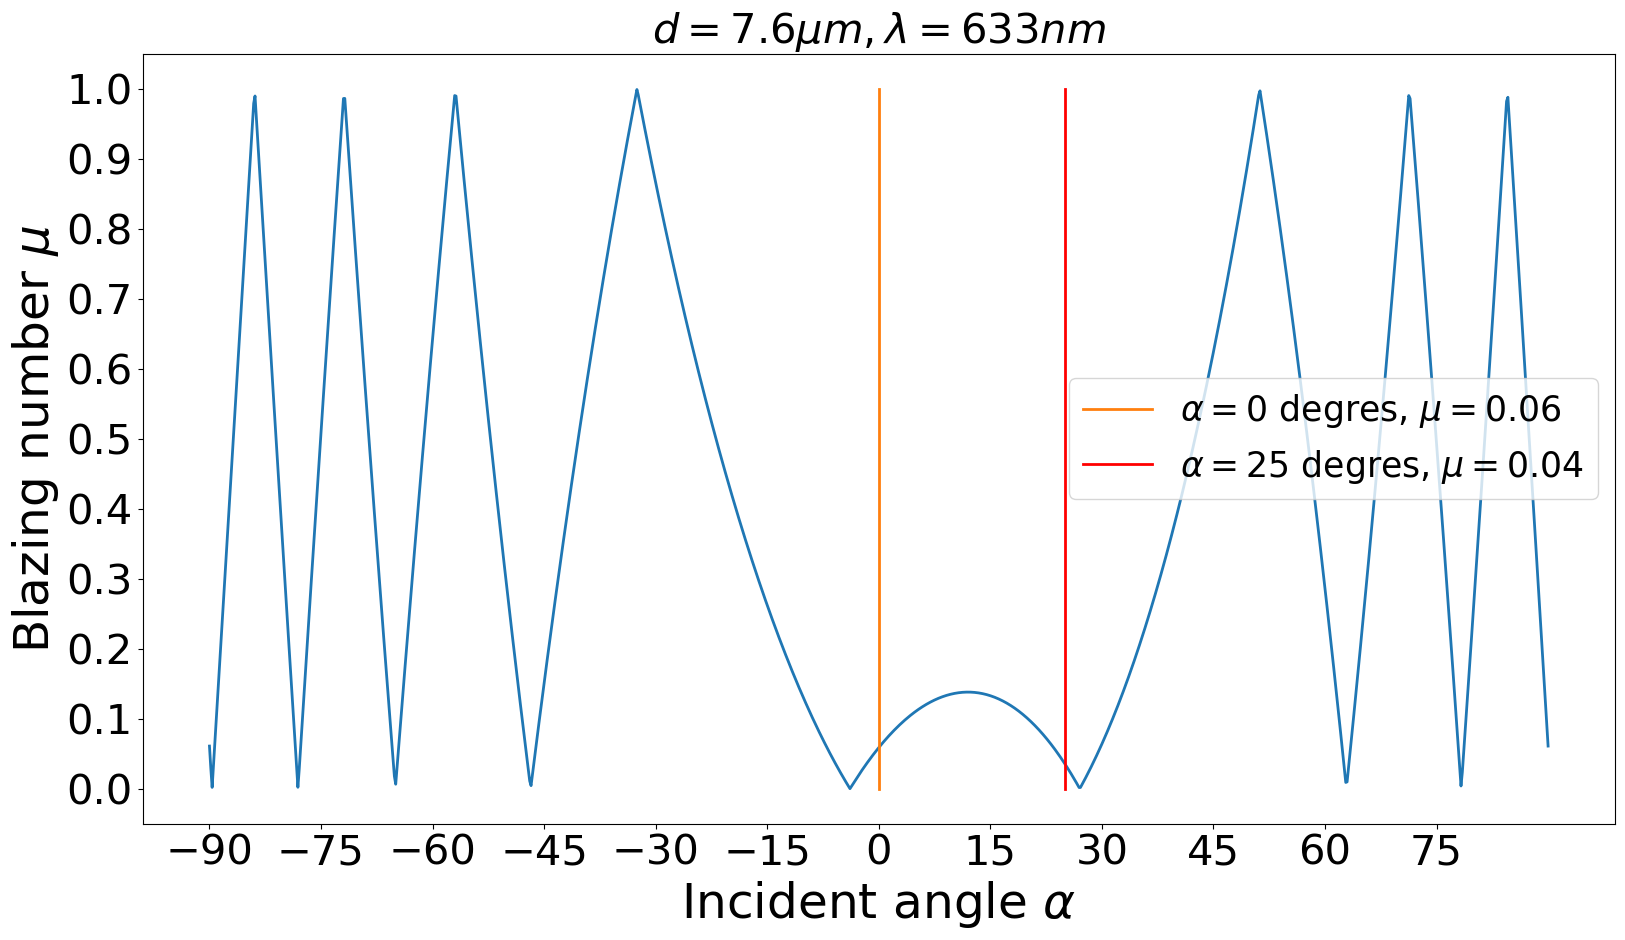

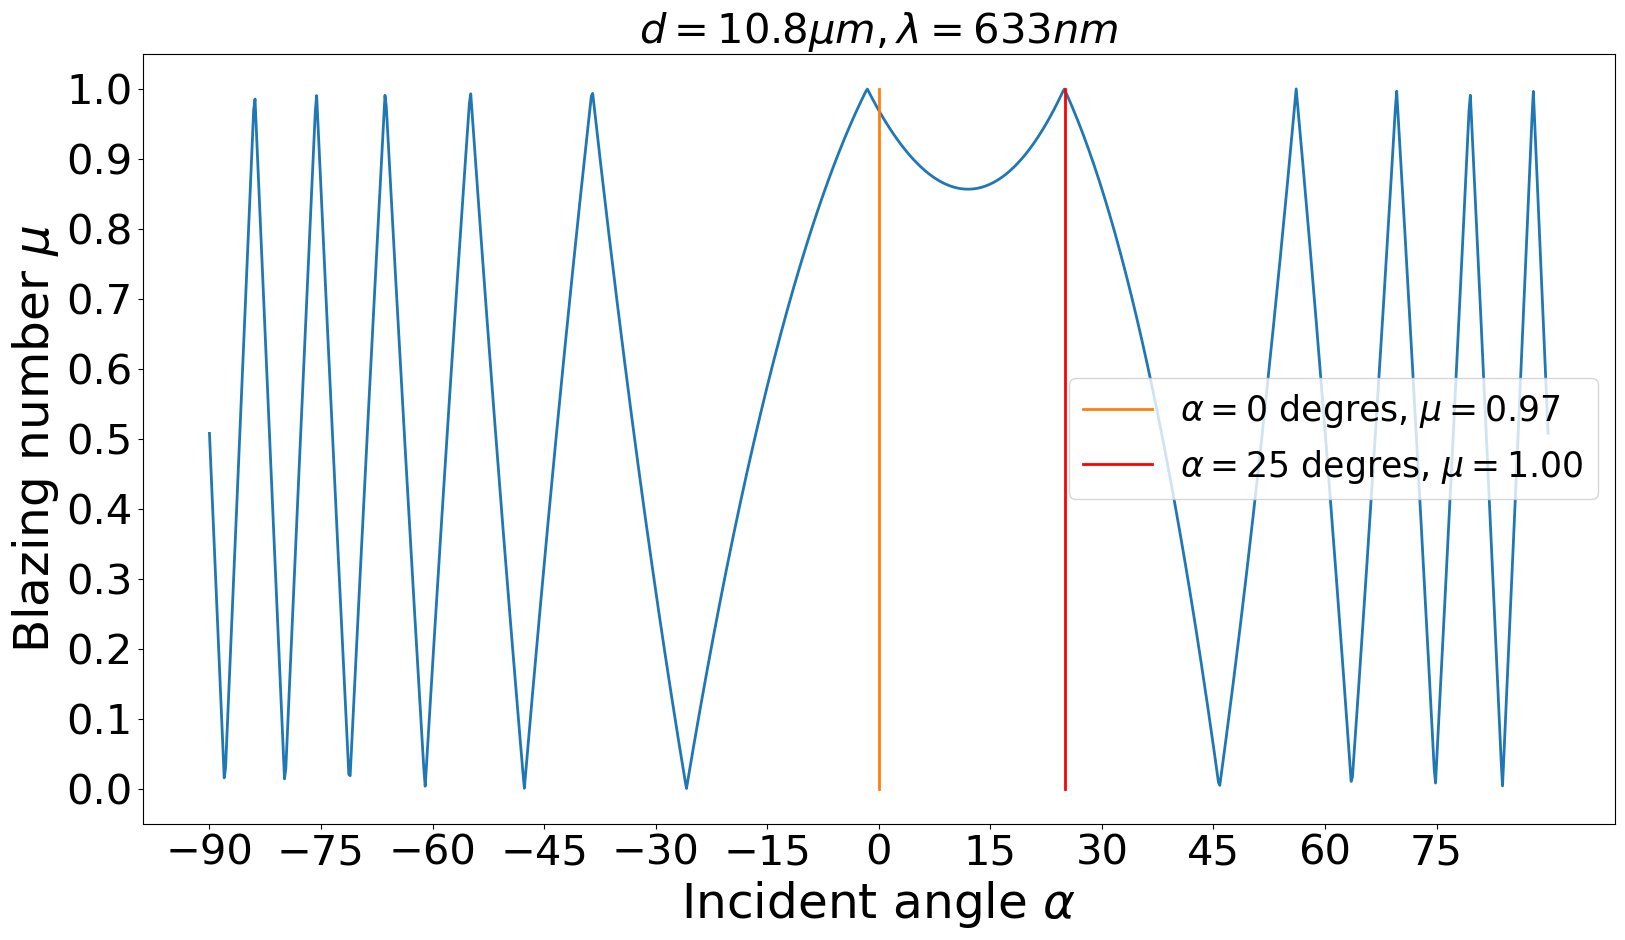

In [114]:

def show_mu(d, theta, _lambda, alphas):
    max_val = 1

    f_mu = get_mu(d, theta, _lambda)
    
    alpha_vec = np.linspace(-np.pi/2,np.pi/2,1000)
    alpha_1D_vec = np.arctan(np.tan(alpha_vec)/np.sqrt(2))

    criterion = np.fromiter((f_mu(a) for a in alpha_1D_vec), np.float)

    plt.figure()
    plt.plot(alpha_vec*180/np.pi,criterion,linewidth = 2)

    def get_label(alpha):
        alpha_1D = np.arctan(np.tan(alpha)/np.sqrt(2))
        label =  rf'$\alpha = {alpha*180/np.pi:.0f}$ degrees, $\mu = {f_mu(alpha_1D):.2f}$'
        return label
    plt.plot([alphas[0]*180/np.pi]*2,[0.,max_val],label = get_label(alphas[0]), linewidth = 2)
    plt.plot([alphas[1]*180/np.pi]*2,[0.,max_val],label = get_label(alphas[1]), color = 'red',linewidth = 2)
    # plt.plot([0,0],[0.,max_val],color = 'red',linewidth = 2)
    plt.xticks(np.arange(-90,90,15),fontsize = 30)
    plt.yticks(np.arange(0,max_val+0.05,0.1),fontsize = 30)
    plt.title(r'$d=%.1f\mu m, \lambda =%g nm$' % (d,1e3*_lambda),fontsize = 30)
    plt.legend(fontsize = 25,loc='center right')
    plt.ylabel(r'Blazing number $\mu$', fontsize = 35)
    plt.xlabel(r'Incident angle $\alpha$', fontsize = 35)
    image_prefix = f'blazing_angle_d{d:.1f}_theta{theta:.1f}_lambda{_lambda:.1f}_alpha{alpha:.1f}'
    plt.savefig(image_prefix+'_mu.svg', dpi = 300)

show_mu(d, theta, _lambda, alphas = [alpha1,alpha2])
show_mu(10.8, theta, _lambda, alphas = [alpha1,alpha2])

In [33]:
## A full numerical simulation of the Fourier plane for an all-on configuration

N = 20 # number of mirrors in each direction
g = 2 # gap between pixels in micron
res = 10 # pixels per mirror (for numerical calculation)
Nx = N*res

In [118]:
def show_2d(d, theta, _lambda, alpha):
    beta = -alpha +2*theta # reflection angle
    alpha_1D = np.arctan(np.tan(alpha)/np.sqrt(2))
    theta_1D = np.arctan(np.tan(theta)/np.sqrt(2))
    beta_1D = 2*theta_1D-alpha_1D

    image_prefix = f'blazing_angle_d{d:.1f}_theta{theta*180/np.pi:.1f}_lambda{_lambda:.1f}_alpha{alpha*180/np.pi:.1f}'
    
    ## Pixelate image function
    f = np.ones([N,N]) # all-on configuration
    ## Phase slope due to incident and reflection angle
    X,Y = np.meshgrid(np.arange(N),np.arange(N))
    phi = np.exp((X-Y)*complex(0,1)*2*np.pi/_lambda*d*(np.sin(alpha_1D)+np.sin(beta_1D)))
    ## cell unit
    Cell = np.zeros([res,res])
    gpix = int(np.round(g/(2.*d)*res))
    x,y = np.meshgrid(np.arange(res),np.arange(res))
    Mask_cell = np.zeros([res,res]);
    Mask_cell[gpix:res-gpix,gpix:res-gpix] = 1
    Cell = Mask_cell
    ## Mirror image
    MI = np.zeros([Nx,Nx],dtype='complex')
    for i in range(N):
        for j in range(N):
            MI[i*res:(i+1)*res,j*res:(j+1)*res]= f[i,j]*phi[i,j]*Cell
    # plt.figure()
    # plt.imshow(np.real(MI),interpolation = 'None')
    ## In the Fourier plane
    coeff = 5
    FP = np.fft.fftshift(np.fft.fft2(MI,s=[coeff*Nx,coeff*Nx]))
    ROIsize = 500
    ROI = 1
    plt.figure()
    plt.imshow((np.abs(FP[coeff*Nx//2-ROIsize//2:coeff*Nx//2+ROIsize//2,coeff*Nx//2-ROIsize//2:coeff*Nx//2+ROIsize//2]))**2,interpolation = 'None')
    plt.clim([0,(np.max(np.abs(FP)**2))/1.5])
    plt.scatter(ROIsize//2, ROIsize//2, s=500, edgecolors='red',alpha = 0.5,c='yellow',linewidths= 3.,  marker='x')
    plt.axis('off')
    plt.title(r'$\alpha = %.0f$ degres' % (alpha*180/np.pi),fontsize = 30)
    plt.savefig(image_prefix + '_farfield.svg', dpi = 300)

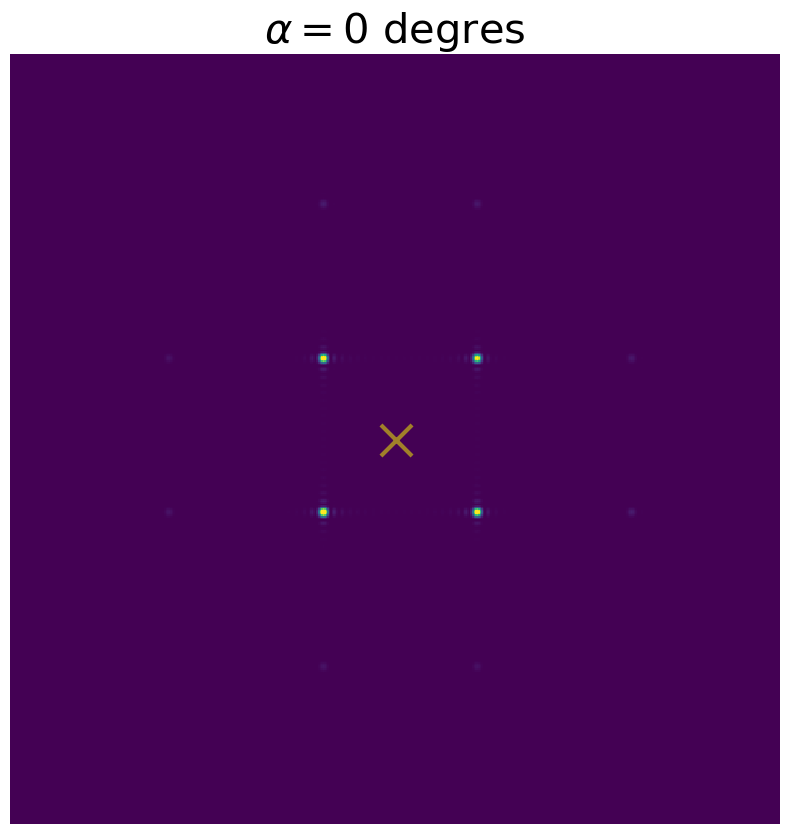

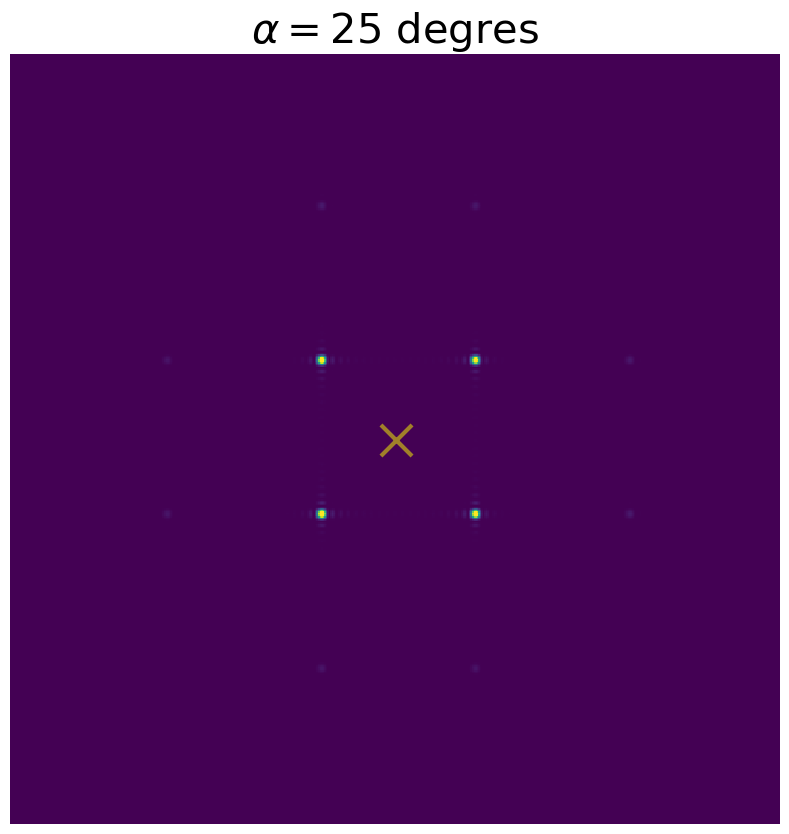

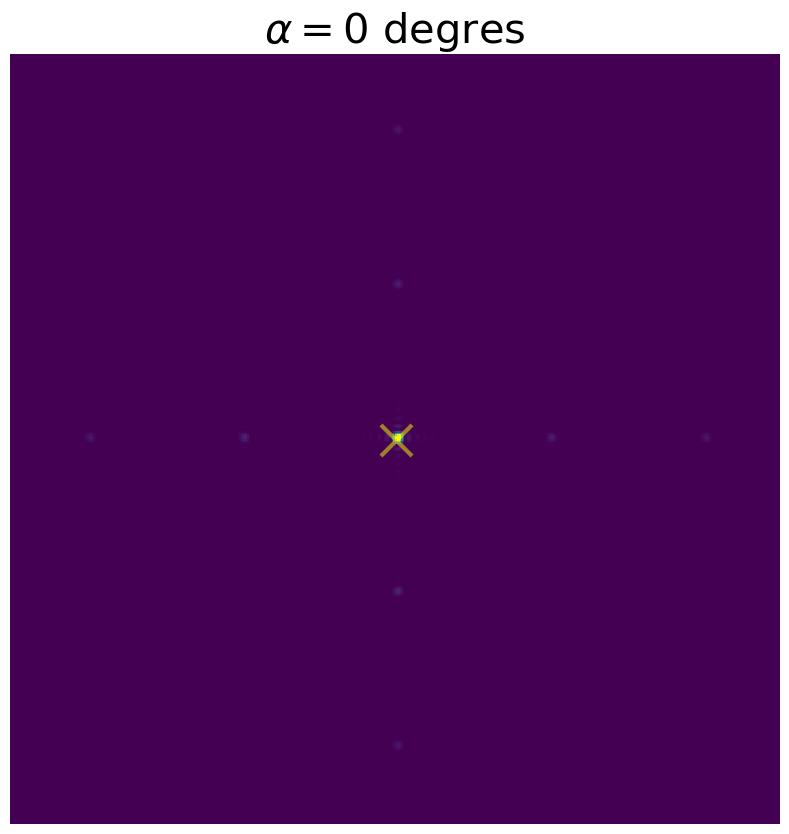

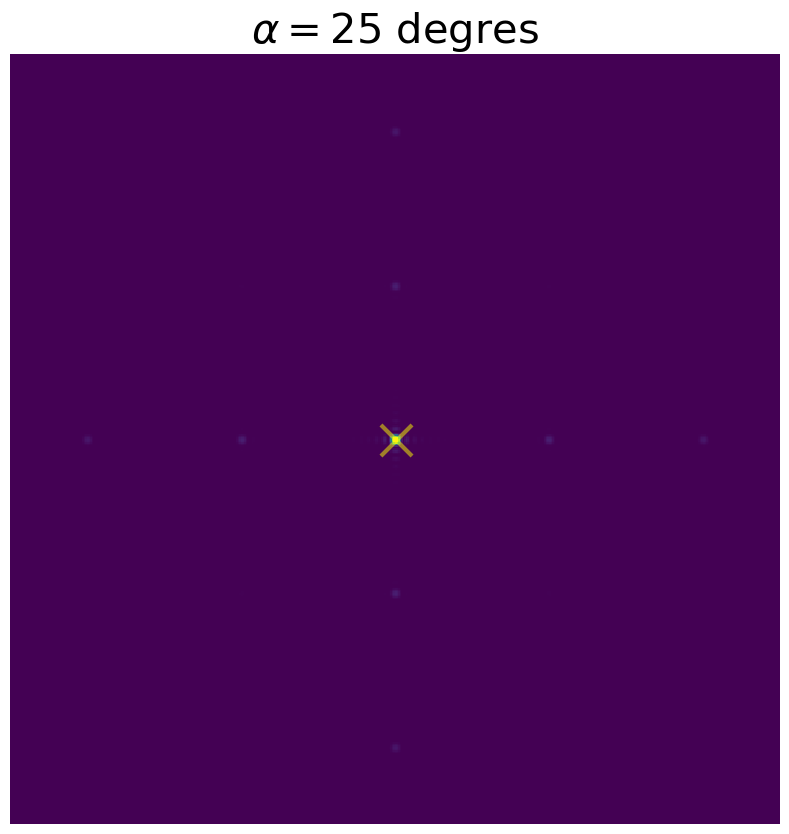

In [119]:
# alpha2 = 25./180*np.pi
show_2d(d = 7.6, theta = theta, _lambda = _lambda, alpha =  alpha1)
show_2d(d = 7.6, theta = theta, _lambda = _lambda, alpha =  alpha2)
show_2d(d = 10.8, theta = theta, _lambda = _lambda, alpha =  alpha1)
show_2d(d = 10.8, theta = theta, _lambda = _lambda, alpha =  alpha2)